# Обучение однослойного персептрона методом коррекции по ошибке через дельта-правило


## Загрузка датасета, предобработка данных

In [1]:
PATH = '/content/drive/MyDrive/Inga/Data/Data for labs/MNIST lab 1 MTUSI'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
transform = transforms.Compose([transforms.Resize(28),
                                transforms.ToTensor()])
train_dataset = datasets.ImageFolder(PATH+'/Train', transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
images, labels = next(iter(dataloader))

Наши картинки имеют по 3 канала, но использование всех 3 в данной задаче излишне - можно выбрать любой канал.

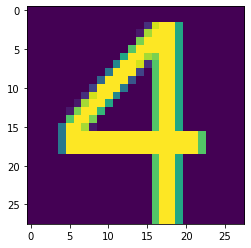

In [2]:
plt.imshow(images[0][0])

In [3]:
images = images[:, 0]
images = images.reshape(24, 28*28)

## Архитектура сети:

Создадим однослойный персептрон. \\

Входной слой: 784 x 1 \\

Метод обучения: дельта-правило (см. torch.optim.Adadelta)


In [6]:
import torch
from torch.nn import Linear

In [7]:
input_size = 784
output_size = 1

In [18]:
mlp = torch.nn.Sequential(
    Linear(input_size, output_size)
).to('cuda')

loss_fn = torch.nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adadelta(mlp.parameters(), lr=learning_rate)
num_epoch = 5000

In [19]:
train_data = torch.cuda.FloatTensor(images.numpy(), device='cuda')
train_labels = torch.cuda.FloatTensor(labels.numpy(), device='cuda')

loss_curve = []
for epoch in range(num_epoch):
    y_pred = mlp(train_data)
    loss = loss_fn(y_pred.reshape(-1), train_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:

        print('Epoch:', epoch, 'Loss:', loss.item())
        loss_curve.append(loss.item())
    

Epoch: 0 Loss: 8.996072769165039
Epoch: 50 Loss: 8.858869552612305
Epoch: 100 Loss: 8.70145034790039
Epoch: 150 Loss: 8.528950691223145
Epoch: 200 Loss: 8.344348907470703
Epoch: 250 Loss: 8.150070190429688
Epoch: 300 Loss: 7.948158264160156
Epoch: 350 Loss: 7.740360260009766
Epoch: 400 Loss: 7.528192043304443
Epoch: 450 Loss: 7.312984466552734
Epoch: 500 Loss: 7.095893383026123
Epoch: 550 Loss: 6.877941131591797
Epoch: 600 Loss: 6.660037994384766
Epoch: 650 Loss: 6.442995071411133
Epoch: 700 Loss: 6.227529048919678
Epoch: 750 Loss: 6.014264106750488
Epoch: 800 Loss: 5.8037543296813965
Epoch: 850 Loss: 5.596482753753662
Epoch: 900 Loss: 5.392856597900391
Epoch: 950 Loss: 5.1932148933410645
Epoch: 1000 Loss: 4.997837066650391
Epoch: 1050 Loss: 4.806944847106934
Epoch: 1100 Loss: 4.620713233947754
Epoch: 1150 Loss: 4.439291954040527
Epoch: 1200 Loss: 4.262797832489014
Epoch: 1250 Loss: 4.091307640075684
Epoch: 1300 Loss: 3.9248738288879395
Epoch: 1350 Loss: 3.763512372970581
Epoch: 1400 L

Text(0, 0.5, 'loss')

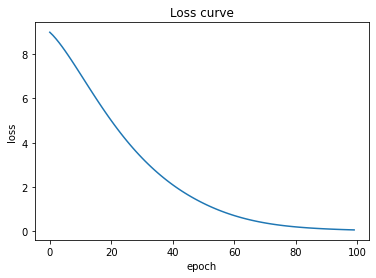

In [20]:
from matplotlib import pyplot as plt

plt.plot(loss_curve)
plt.title('Loss curve')
plt.xlabel('epoch')
plt.ylabel('loss')

In [21]:
from sklearn.metrics import accuracy_score
preds = y_pred.detach().cpu().numpy().round()
print("Точность на обучении:", accuracy_score(train_labels.detach().cpu().numpy(), preds))

Точность на обучении: 0.9583333333333334


## Тестирование:

In [47]:
test_dataset = datasets.ImageFolder(PATH+'/Test', transform=transform)
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
test_images, test_labels = next(iter(dataloader))

test_images = test_images[:, 0]
test_images = test_images.reshape(6, 28*28)

In [48]:
test_data = torch.cuda.FloatTensor(test_images.numpy(), device='cuda')
test_preds = mlp(test_data).detach().cpu().numpy().round()

In [49]:
print("Точность на тесте:", accuracy_score(test_labels.numpy(), test_preds))

Точность на тесте: 0.8333333333333334


### Где ошибка?

In [50]:
test_labels = test_labels.numpy().astype(int)
test_preds = test_preds.reshape(-1).astype(int)

In [52]:
wrong_ans = test_preds != test_labels
bad_classification_X = test_data[wrong_ans]
wrong_preds = test_preds[wrong_ans]

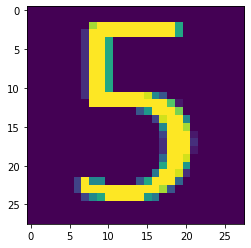

In [58]:
plt.imshow(bad_classification_X.cpu().detach().numpy().reshape(28, 28))

In [62]:
print("Модель считает, что это", wrong_preds[0])

Модель считает, что это 4


## Выводы:

Сеть данной архитектуры способна решать данную задачу просто как задачу регрессии, что говорит о том, что изображения цифр оказались хорошо линейно разделимы в пространстве векторов размера 784. \\

Однако вряд ли у нашей сети есть серъезная способность к генерализации - на столь малом датасете такие выводы делать не стоит. Скорее всего сеть просто переобучилась на тренировочную выборку (что видно по лосс-кривой), и может выдавать ответы только на данных, очень похожих на тренировочные.